<a href="https://colab.research.google.com/github/KangTuna/Machine-learning-and-deep-learning-practices/blob/main/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.Resize(112),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 71921241.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
batch_size = 50

train_loader = DataLoader(
    train_set, batch_size= batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set, batch_size= batch_size,
    shuffle = False
)

In [ ]:
#  라이브러리 임포트
from torchvision import models

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터를 동시에 불러오기
net = models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [ ]:
# 모델 개요 표시 1

print(net)

In [ ]:
!pip install torchinfo | tail -n 1

In [ ]:
from torchinfo import summary
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

In [ ]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


In [ ]:
n_output = len(classes)
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 최종 레이어 함수의 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

In [ ]:
# 모델 개요 표시 1
print(net)

In [ ]:
# 모델 개요 표시 2

net = net.to(device)
summary(net,(100,3,224,224))

In [ ]:
n_output = len(classes)
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터도 함께 불러오기
model1 = models.resnet18(pretrained = True)

# 최종 레이어 함수 입력 차원수 확인
fc_in_features = model1.fc.in_features

# 최종 레이어 함수 교체
model1.fc = nn.Linear(fc_in_features, n_output)

# GPU 사용
model1 = model1.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

# history 파일 초기화
history_m1= np.zeros((0,5))

In [ ]:
num_epochs = 50
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm
for epoch in range(num_epochs):
  train_acc_m1, train_loss_m1 = 0, 0
  test_acc_m1, test_loss_m1 = 0, 0
  n_train, n_test = 0, 0

  for images, labels in tqdm(train_loader):
    n_train += len(labels)

    inputs = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model1(inputs)
    loss_model1 = criterion(outputs, labels)
    loss_model1.backward()
    optimizer.step()
    pred_m1 = outputs.max(axis=1)[1]
    train_loss_m1 += loss_model1.item()
    train_acc_m1 += (pred_m1 == labels).sum().item()
  for images_test, labels_test in test_loader:
    n_test += len(labels_test)

    inputs_test = images_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model1(inputs_test)

    loss_test_model1 = criterion(outputs_test, labels_test)

    pred_test_m1 = outputs_test.max(axis=1)[1]

    test_loss_m1 +=  loss_test_model1.item()
    test_acc_m1 +=  (pred_test_m1 == labels_test).sum().item()

  train_acc_m1 = train_acc_m1 / n_train
  test_acc_m1 = test_acc_m1 / n_test
  train_loss_m1 = train_loss_m1 / n_train
  test_loss_m1 = test_loss_m1 / n_test
  print(f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss_m1:.5f}, loss_test: {test_loss_m1:.5f}')
  item = np.array([epoch+1 , train_loss_m1, train_acc_m1, test_loss_m1, test_acc_m1])
  history_m1 = np.vstack((history_m1, item))

In [ ]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history_m1[0,3]:.5f}  정확도 : {history_m1[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history_m1[-1,3]:.5f}  정확도 : {history_m1[-1,4]:.5f}' )

초기상태 : 손실 : 0.00997  정확도 : 0.83190
최종상태 : 손실 : 0.00666  정확도 : 0.88980


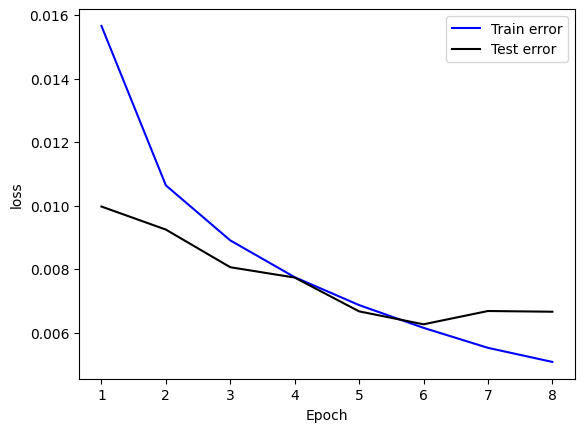

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history_m1[:,0], history_m1[:,1], 'b', label='Train error')
plt.plot(history_m1[:,0], history_m1[:,3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

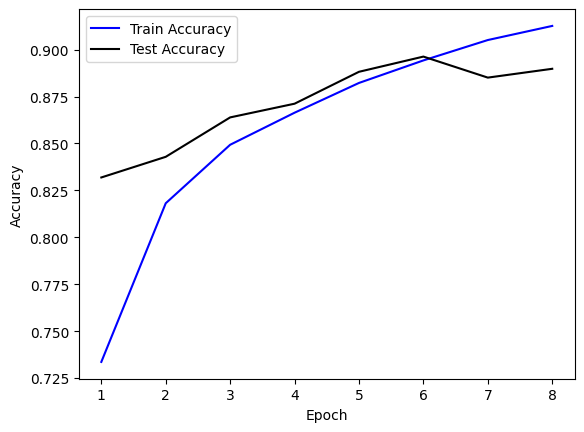

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history_m1[:,0], history_m1[:,2], 'b', label='Train Accuracy')
plt.plot(history_m1[:,0], history_m1[:,4], 'k', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()